<a href="https://colab.research.google.com/github/ericodle/uddf_analytics/blob/main/UDDF_3Dtraj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dive computers store data in standard UDDF (Universal Dive Data Format)...format. 
If you open one of these files in a text editor, you get a block of text with various tags and values. To make sense of this infomation, we must first parse it.
The base standard is XML (eXtensible Markup Language), which Python conveniently has a built-in library to read.

In [91]:
# Original UDDF fule transferred from my ATMOS dive computer. 
# Upload from local machine to colab notebook. 
# https://github.com/ericodle/uddf_analytics/blob/main/example.uddf
# Note: the directly downloaded file doesn't seem to work with the parser.

divelog = "/content/example.uddf"

In [95]:
# This is the Python parser we will use.
import xml.etree.ElementTree as ET

tree = ET.parse(divelog)
root = tree.getroot()

print("Root Tag:")
print(root.tag)

print("Root Attribute:")
print(root.attrib)

Root Tag:
uddf
Root Attribute:
{'version': '3.2.3'}


We are exploring a tree, so let's see what branches they give us.

In [96]:
for child in root:
    print(child.tag, child.attrib)

generator {}
diver {}
divesite {}
gasdefinitions {}
profiledata {}


In [98]:
# List all the types of dive data provided by your dive computer.
[elem.tag for elem in root.iter()]

['uddf',
 'generator',
 'name',
 'type',
 'manufacturer',
 'name',
 'contact',
 'language',
 'homepage',
 'email',
 'Version',
 'diver',
 'owner',
 'personal',
 'firstname',
 'lastanme',
 'sex',
 'equipment',
 'divecomputer',
 'name',
 'manufacturer',
 'name',
 'contact',
 'model',
 'serialnumber',
 'divesite',
 'gasdefinitions',
 'mix',
 'name',
 'o2',
 'n2',
 'profiledata',
 'repetitiongroup',
 'dive',
 'informationbeforedive',
 'link',
 'internaldivenumber',
 'airtemperature',
 'datetime',
 'surfacepressure',
 'tankdata',
 'link',
 'informationafterdive',
 'lowesttemperature',
 'greatestdepth',
 'diveduration',
 'averagedepth',
 'equipmentused',
 'link',
 'samples',
 'waypoint',
 'divetime',
 'depth',
 'divemode',
 'heading',
 'nodecotime',
 'temperature',
 'waypoint',
 'divetime',
 'depth',
 'heading',
 'nodecotime',
 'temperature',
 'waypoint',
 'divetime',
 'depth',
 'heading',
 'nodecotime',
 'temperature',
 'waypoint',
 'divetime',
 'depth',
 'heading',
 'nodecotime',
 'tempera

First, let's look at the divetime data. This may tell us something about how the dive computer records information.

In [99]:
for divetime in root.iter('divetime'):
    print(divetime.text)

0
3
6
9
12
15
18
21
24
27
30
33
36
39
42
45
48
51
54
57
60
63
66
69
72
75
78
81
84
87
90
93
96
99
102
105
108
111
114
117
120
123
126
129
132
135
138
141
144
147
150
153
156
159
162
165
168
171
174
177
180
183
186
189
192
195
198
201
204
207
210
213
216
219
222
225
228
231
234
237
240
243
246
249
252
255
258
261
264
267
270
273
276
279
282
285
288
291
294
297
300
303
306
309
312
315
318
321
324
327
330
333
336
339
342
345
348
351
354
357
360
363
366
369
372
375
378
381
384
387
390
393
396
399
402
405
408
411
414
417
420
423
426
429
432
435
438
441
444
447
450
453
456
459
462
465
468
471
474
477
480
483
486
489
492
495
498
501
504
507
510
513
516
519
522
525
528
531
534
537
540
543
546
549
552
555
558
561
564
567
570
573
576
579
582
585
588
591
594
597
600
603
606
609
612
615
618
621
624
627
630
633
636
639
642
645
648
651
654
657
660
663
666
669
672
675
678
681
684
687
690
693
696
699
702
705
708
711
714
717
720
723
726
729
732
735
738
741
744
747
750
753
756
759
762
765
768
771
774
77

The dive was 54 min 19 sec, which works out to 3259 seconds. With a start time of 0 and values apparently logged every 3 seconds, a final divetime value of 3255 passes the common sense test. 

Next, we look at the same data but for depth (unit = meters). Note an error of +/- 0.2 meters, which was also the discrepency between the Atmos and my Suunto. I guess this is within sensor tolerance.

In [101]:
for depth in root.iter('depth'):
    print(depth.text)

2.625
2.675
2.675
2.965
3.265
3.555
3.635
3.625
3.405
3.415
3.805
3.965
3.875
3.425
3.755
3.565
3.305
3.555
3.385
3.295
3.285
3.425
3.535
3.355
3.535
3.565
3.615
3.325
3.195
2.945
2.705
2.745
2.705
2.685
2.645
2.805
2.905
3.025
3.095
3.215
3.325
3.325
3.325
3.425
3.325
3.385
3.405
3.225
3.155
3.145
3.205
2.975
2.925
3.035
3.175
3.135
3.045
3.055
3.135
3.065
3.115
3.435
3.675
3.805
3.605
4.105
4.405
4.445
4.505
4.455
4.425
4.345
4.345
4.675
4.725
4.825
4.905
4.985
5.305
5.205
5.135
5.275
5.285
5.115
5.115
5.045
5.085
5.105
5.015
5.175
5.285
5.275
5.345
5.335
5.285
5.415
5.625
5.735
5.805
5.975
6.155
6.085
6.015
6.015
5.865
5.915
5.855
5.785
5.975
6.035
5.925
5.935
6.035
6.045
6.375
6.535
6.505
6.605
6.665
6.825
7.055
7.155
7.275
7.375
7.245
7.275
7.255
7.335
7.365
7.835
8.045
8.195
8.415
8.515
8.875
8.855
8.735
8.825
8.785
8.795
8.835
8.905
9.035
9.045
8.935
8.935
8.895
9.055
9.275
9.415
9.425
9.275
9.325
9.225
8.985
8.955
8.945
8.925
9.045
9.105
9.235
9.275
9.415
9.615
9.625
9.435
9.79

One more time for compass values, which will not be a true indicator of heading given that the computer was strapped to my constantly-moving wrist during the dive.

In [102]:
for heading in root.iter('heading'):
    print(heading.text)

105
93
63
123
88
116
85
87
92
187
70
69
87
215
92
176
55
108
99
86
76
57
78
77
65
66
50
39
26
199
73
43
39
25
90
50
26
27
25
358
14
4
4
358
48
30
39
34
55
38
48
147
71
17
11
352
355
17
21
17
334
37
69
90
66
53
82
101
351
328
335
1
15
352
333
344
326
48
29
24
68
58
23
57
20
27
31
48
38
25
25
324
32
42
34
23
51
20
17
42
25
356
344
350
7
36
9
2
356
4
353
349
326
311
10
322
34
16
10
21
19
31
29
14
37
346
54
30
16
356
70
354
13
38
24
354
332
354
26
21
341
342
344
346
296
325
342
358
354
5
28
46
59
38
16
34
12
18
14
17
29
60
49
58
42
51
26
48
59
22
14
20
33
33
115
70
101
18
358
354
352
350
182
109
137
170
197
235
199
184
121
175
99
85
109
159
167
166
173
126
156
138
55
136
103
79
91
80
77
78
77
67
170
68
60
58
8
35
16
24
21
18
7
6
2
13
29
1
332
48
48
31
54
51
37
42
44
41
52
69
32
22
26
49
355
13
356
10
20
33
22
123
28
23
26
25
42
63
50
61
54
57
22
9
26
48
9
3
14
50
27
36
37
145
95
101
147
189
197
203
192
230
250
204
191
202
158
94
154
134
102
65
115
52
86
111
49
68
17
105
109
131
37
15
35
11

These values range from 0 to 360, so I'm assuming the unit is Degrees.

Let's store time, depth, and heading as their own variables.

In [26]:
dive_time = []
for divetime in root.iter('divetime'):
    dive_time.append(divetime.text)

dive_depth = []
for depth in root.iter('depth'):
    dive_depth.append(depth.text)

dive_heading = []
for heading in root.iter('heading'):
    dive_heading.append(heading.text)

Quick common sense check: all three lists should be the same length, given our assumption that the data will be paired and sequential for our rudimentary trajectory calculation.

In [104]:
print(len(dive_time))
print(len(dive_depth))
print(len(dive_heading))

1086
1086
1086


We almost have all the pieces necessary to construct a 3D trajectory. Since the accelerometer data was not included in the dive log file, we need to make a few unrealistic but model-simplifying assumptions.

First, we assume that from the start of the dive to the end of the dive, the diver was moving at a constant rate in an orientation perfectly normal to the center of the earth.

Second, we assume no current.

Third, as stated previously, we assume the compass reflects the true diver heading.

Under these assumptions, we can construct a step-wise trajectory in 3D space. 
I want to try a connect-the-dots approach. Given a known heading and speed, we can calculate XYZ positions at each time step. How about....each step is a 4-element tuple (t,x,y,z) and the whole route is a list? 

In [105]:
import numpy as np
import math

# Trigonometry experts, please check my logic.

def pol2cart_x(diverSpeed, phi):
    x = float(diverSpeed) * np.cos(math.radians(float(phi)))
    return(x)

def pol2cart_y(diverSpeed, phi):
    y = float(diverSpeed) * np.sin(math.radians(float(phi)))
    return(y)

The above functions will calculate X and Y movement at each step based on a known diver swim speed and heading angle (taken from wrist computer compass in this example).

In [106]:
route = []

diver_speed = 1 # Arbitrary unitless value for easy polar -> cartesian conversion

# x and y are going to change with each iteration of the FOR loop,
# so we need to keep track of them.
x = 0 # x-axis is taken as the North-South axis
y = 0 # y-axis is taken as the East-West axis

for i in range(0,len(dive_time)):
  t = dive_time[i]
  x += pol2cart_x(diver_speed, dive_heading[i])
  y += pol2cart_y(diver_speed, dive_heading[i])
  z = float(dive_depth[i]) * (-1) # z-axis is taken as depth.

  route.append((t, x, y, z))

Let's print out our route and see if everything looks good.

In [107]:
route

[('0', -0.25881904510252085, 0.9659258262890683, -2.625),
 ('3', -0.3111550013454647, 1.9645553610436421, -2.675),
 ('6', 0.1428354983940821, 2.85556188523201, -2.675),
 ('9', -0.401803536620945, 3.694232453177434, -2.965),
 ('12', -0.3669040399184439, 4.69362328019653, -3.265),
 ('15', -0.8052751867075214, 5.5924173264956965, -3.555),
 ('18', -0.7181194439598633, 6.588612024587442, -3.635),
 ('21', -0.6657834877169193, 7.587241559342016, -3.625),
 ('24', -0.7006829844194202, 8.586632386361112, -3.405),
 ('27', -1.6932291360607423, 8.464763042955964, -3.415),
 ('30', -1.3512089927350734, 9.404455663741873, -3.805),
 ('33', -0.9928410431897731, 10.338036090239074, -3.965),
 ('36', -0.9405050869468291, 11.336665624993648, -3.875),
 ('39', -1.759657131235821, 10.763089188642601, -3.425),
 ('42', -1.7945566279383218, 11.762480015661696, -3.755),
 ('45', -2.7921206781981462, 11.83223648940582, -3.565),
 ('48', -2.2185442418471, 12.651388533694812, -3.305),
 ('51', -2.5275612362220476, 13.60

We now have X's, Y's, and Z's. Let's plot them. 
Pandas dataframes are more familiar to me here.

In [108]:
import pandas as pd
df = pd.DataFrame(route, columns =['time', 'x', 'y', 'z'], dtype = float)

Check the DataFrame.

In [109]:
df

,time,x,y,z
0,0.0,-0.258819,0.965926,-2.625
1,3.0,-0.311155,1.964555,-2.675
2,6.0,0.142835,2.855562,-2.675
3,9.0,-0.401804,3.694232,-2.965
4,12.0,-0.366904,4.693623,-3.265
...,...,...,...,...
1081,3243.0,-98.242219,-69.864725,0.205
1082,3246.0,-99.071257,-69.305532,0.215
1083,3249.0,-99.890409,-69.879109,0.225
1084,3252.0,-100.709561,-70.452685,0.195


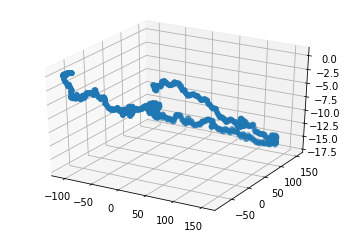

In [110]:
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(df["x"], df["y"], df["z"])

The route goes down, then comes up, following roughly the same path out and in.This is what we did at Bat Cave (northern Taiwan) during our annual underwater beach cleanup when the data was logged.

Getting interactive MatPlotLib graphs to work in Google Colab is tricky. If you run this on your local computer you can probably rotate the trajectory in 3D.

Dive computers provide a wealth of data for divers to analyze independently. 